In [90]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cm
import os

from stompy import utils
from stompy.grid import unstructured_grid
from stompy.model.delft import dfm_grid

%matplotlib notebook

In [2]:
import six
six.moves.reload_module(unstructured_grid)

<module 'stompy.grid.unstructured_grid' from '/home/rusty/python/stompy/grid/unstructured_grid.py'>

In [3]:
ls runs

S42.0_D3.0_Q02.0/  S45.0_D3.0_Q02.0/  S48.0_D3.0_Q02.0/  test00/
S42.0_D3.0_Q10.0/  S45.0_D3.0_Q10.0/  S48.0_D3.0_Q10.0/  test01/
S42.0_D3.0_Q25.0/  S45.0_D3.0_Q25.0/  S48.0_D3.0_Q25.0/  test02/
S42.0_D6.0_Q02.0/  S45.0_D6.0_Q02.0/  S48.0_D6.0_Q02.0/
S42.0_D6.0_Q10.0/  S45.0_D6.0_Q10.0/  S48.0_D6.0_Q10.0/
S42.0_D6.0_Q25.0/  S45.0_D6.0_Q25.0/  S48.0_D6.0_Q25.0/


In [ ]:
map_nc_fn="runs/S45.0_D3.0_Q25.0/DFM_OUTPUT_flowfm/flowfm_map.nc"
map_nc=xr.open_dataset(map_nc_fn)

In [63]:
run_name=map_nc_fn.split('/')[1]

In [5]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(map_nc)

<IPython.core.display.Javascript object>


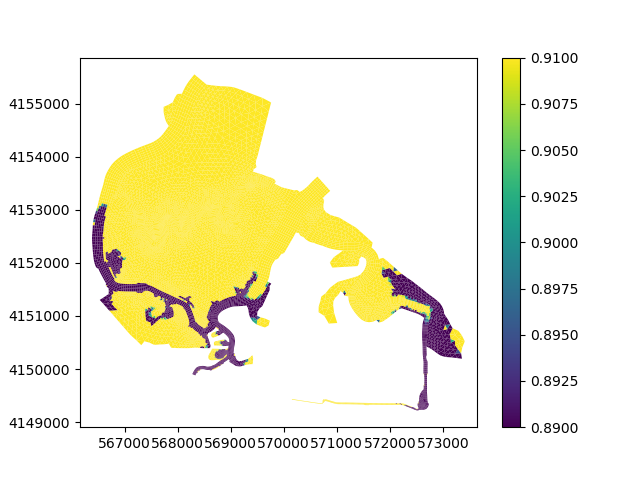

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


(566034.38517967449,
 573765.45475488598,
 4148902.8180150003,
 4155872.0634849998)

In [7]:
scal=map_nc.sa1.isel(time=-1,laydim=0).values

plt.figure()
#g.plot_edges(lw=0.3,color='k')
ccoll=g.plot_cells(values=scal)
ccoll.set_clim([0.89,0.91])
plt.colorbar(ccoll)
plt.axis('equal')

<IPython.core.display.Javascript object>


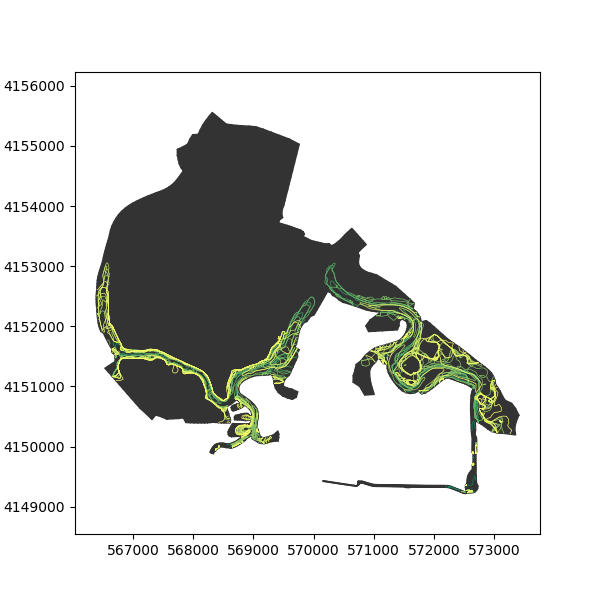

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


(566034.38517967449,
 573765.45475488598,
 4148902.8180150003,
 4155872.0634849998)

In [70]:
release_hour=float(map_nc_fn.split('/')[1].split('_')[0][1:])

# A possible summary figure for a run
# Contours every 0.5h
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,1,1)

g.plot_cells(color="0.2",ax=ax)

start_ti=int(3*(release_hour-1))
stop_ti=min(len(map_nc.time), start_ti+3*26)

tidxs=range(release_ti,stop_ti,3)
for count,ti in enumerate(tidxs):
    scal=map_nc.sa1.isel(time=ti,laydim=0).values
    col=cmap(count/(len(tidxs)-1.0))

    lines=g.scalar_contour(scal,V=[0.9],smooth=True)
    lines.set_color(col)
    lines.set_lw(0.5)
    ax.add_collection(lines)
ax.axis('equal')

In [100]:
class Anim(object):
    def __init__(self,map_nc_fn):
        self.map_nc_fn=map_nc_fn
        self.map_nc=xr.open_dataset(map_nc_fn)
        self.g=unstructured_grid.UnstructuredGrid.from_ugrid(self.map_nc)
        
    def filename_to_metadata(self):
        # get simulation metadata from filename:
        meta_str=self.map_nc_fn.split('/')[1]
        self.release_hour,self.duration_h,self.Q=[float(s[1:]) for s in meta_str.split('_') ]

        # fabricate flow timeseries
        t0=self.map_nc.time.values[0]
        h=np.timedelta64(1,'h')
        self.Q_h=np.array( [0,(self.release_hour-1),
                           self.release_hour,self.release_hour+self.duration_h,
                           self.release_hour+self.duration_h+1,96])
        self.Q_time=t0 + np.timedelta64(1,'h') * self.Q_h
        self.Q_flow=np.array([0,0,Q,Q,0,0])
    def run_name(self):
        return map_nc_fn.split('/')[1]
    def time_indexes(self):
        # Frames for an animation
        start_ti=int(3*(self.release_hour-1))
        stop_ti=min(len(self.map_nc.time), start_ti+3*26)
        return range(start_ti,stop_ti)
    def tide_data(self):
        # cell to use for extracting stage
        chan_cell=np.argmax(map_nc.FlowElem_zcc.values) # 8321
        chan_eta=map_nc.s1.isel(nFlowElem=chan_cell).values
        return chan_eta
    def figure_setup(self):
        # A possible summary figure for a run
        # Contours every 0.5h
        fig=plt.figure(figsize=(8,7))
        ax=fig.add_subplot(1,1,1)
        cax=fig.add_axes([0.8,0.5,0.02,0.3])
        loc=ax.get_position()

        pad_in=0.1
        t_ax=fig.add_axes([loc.xmin+pad_in,loc.ymin-0.08,loc.width-2*pad_in,0.1])
        return fig,dict(ax=ax,t_ax=t_ax,cax=cax)
    def get_scal(self,tidx):
        return 1.0-self.map_nc.sa1.isel(time=tidx,laydim=0).values
    def anim_setup(self):
        self.filename_to_metadata()
        self.tidxs=self.time_indexes()
        chan_eta=self.tide_data()
        self.fig,self.axs=self.figure_setup()

        scal=self.get_scal(self.tidxs[0])

        ax=self.axs['ax']
        
        self.ccoll=self.g.plot_cells(values=scal,ax=ax,cmap='plasma_r')
        self.ccoll.set_clim([0,1.])

        plt.colorbar(ccoll,cax=self.axs['cax'],label="Fraction stormwater")

        ax.axis('equal')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)

        self.hours=hours=(self.map_nc.time.values - self.map_nc.time.values[0])/np.timedelta64(1,'h')

        t_ax=self.axs['t_ax']
        t_ax.plot(hours, chan_eta,'g-')
        Q_ax=self.axs['Q_ax']=t_ax.twinx()
        Q_ax.plot(self.Q_h, self.Q_flow,'b-')

        for time_ax in [t_ax,Q_ax]:
            time_ax.axis( xmin=hours[0],xmax=hours[-1])

        self.fig.subplots_adjust(bottom=0.14,left=0.02,right=0.98,top=0.98)

        t_ax.set_ylabel('Tides (m)')
        Q_ax.set_ylabel('Q (m3/s)')
    def fig_dir(self):
        d=os.path.join("figs-20180609",self.run_name())
        if not os.path.exists(d):
            os.makedirs(d)
        return d
    def update_time(self,tidx):
        scal=self.get_scal(tidx)
        self.ccoll.set_array(scal)
        self.axs['t_ax'].axvline(self.hours[ti],color='k',lw=1.)
    def save_frames(self):
        fd=self.fig_dir()
        for frame,t in enumerate(self.tidxs):
            img_fn=os.path.join(fd,"frame%04d.png"%frame)
            #if os.path.exists(img_fn):
            #    continue
            print(img_fn)
            self.update_time(t)
            self.fig.savefig(img_fn)



In [96]:
A.save_frames()

figs-20180609/S45.0_D3.0_Q25.0/frame0000.png
figs-20180609/S45.0_D3.0_Q25.0/frame0001.png
figs-20180609/S45.0_D3.0_Q25.0/frame0002.png
figs-20180609/S45.0_D3.0_Q25.0/frame0003.png
figs-20180609/S45.0_D3.0_Q25.0/frame0004.png
figs-20180609/S45.0_D3.0_Q25.0/frame0005.png
figs-20180609/S45.0_D3.0_Q25.0/frame0006.png
figs-20180609/S45.0_D3.0_Q25.0/frame0007.png
figs-20180609/S45.0_D3.0_Q25.0/frame0008.png
figs-20180609/S45.0_D3.0_Q25.0/frame0009.png
figs-20180609/S45.0_D3.0_Q25.0/frame0010.png
figs-20180609/S45.0_D3.0_Q25.0/frame0011.png
figs-20180609/S45.0_D3.0_Q25.0/frame0012.png
figs-20180609/S45.0_D3.0_Q25.0/frame0013.png
figs-20180609/S45.0_D3.0_Q25.0/frame0014.png
figs-20180609/S45.0_D3.0_Q25.0/frame0015.png
figs-20180609/S45.0_D3.0_Q25.0/frame0016.png
figs-20180609/S45.0_D3.0_Q25.0/frame0017.png
figs-20180609/S45.0_D3.0_Q25.0/frame0018.png
figs-20180609/S45.0_D3.0_Q25.0/frame0019.png
figs-20180609/S45.0_D3.0_Q25.0/frame0020.png
figs-20180609/S45.0_D3.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


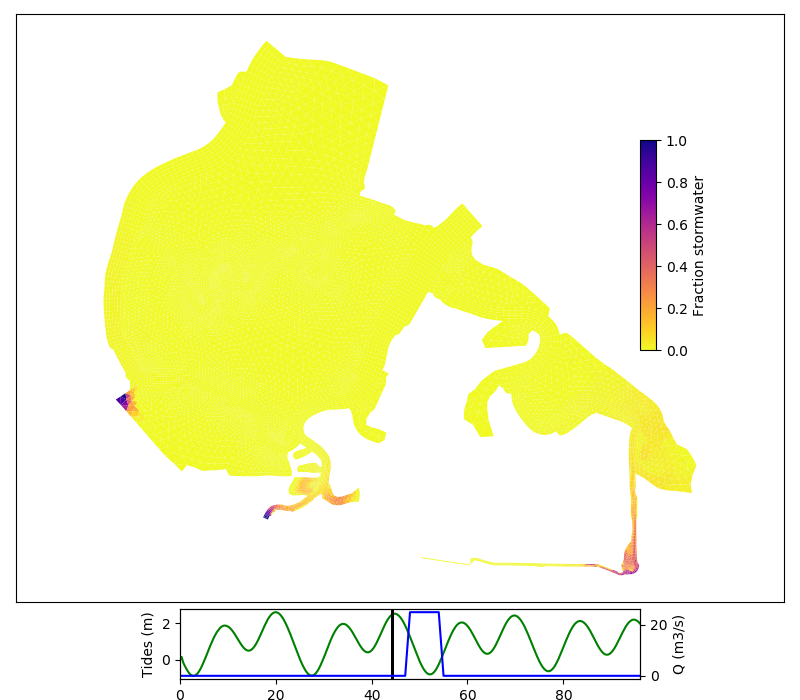

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


figs-20180609/S48.0_D6.0_Q02.0/frame0000.png
figs-20180609/S48.0_D6.0_Q02.0/frame0001.png
figs-20180609/S48.0_D6.0_Q02.0/frame0002.png
figs-20180609/S48.0_D6.0_Q02.0/frame0003.png
figs-20180609/S48.0_D6.0_Q02.0/frame0004.png
figs-20180609/S48.0_D6.0_Q02.0/frame0005.png
figs-20180609/S48.0_D6.0_Q02.0/frame0006.png
figs-20180609/S48.0_D6.0_Q02.0/frame0007.png
figs-20180609/S48.0_D6.0_Q02.0/frame0008.png
figs-20180609/S48.0_D6.0_Q02.0/frame0009.png
figs-20180609/S48.0_D6.0_Q02.0/frame0010.png
figs-20180609/S48.0_D6.0_Q02.0/frame0011.png
figs-20180609/S48.0_D6.0_Q02.0/frame0012.png
figs-20180609/S48.0_D6.0_Q02.0/frame0013.png
figs-20180609/S48.0_D6.0_Q02.0/frame0014.png
figs-20180609/S48.0_D6.0_Q02.0/frame0015.png
figs-20180609/S48.0_D6.0_Q02.0/frame0016.png
figs-20180609/S48.0_D6.0_Q02.0/frame0017.png
figs-20180609/S48.0_D6.0_Q02.0/frame0018.png
figs-20180609/S48.0_D6.0_Q02.0/frame0019.png
figs-20180609/S48.0_D6.0_Q02.0/frame0020.png
figs-20180609/S48.0_D6.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


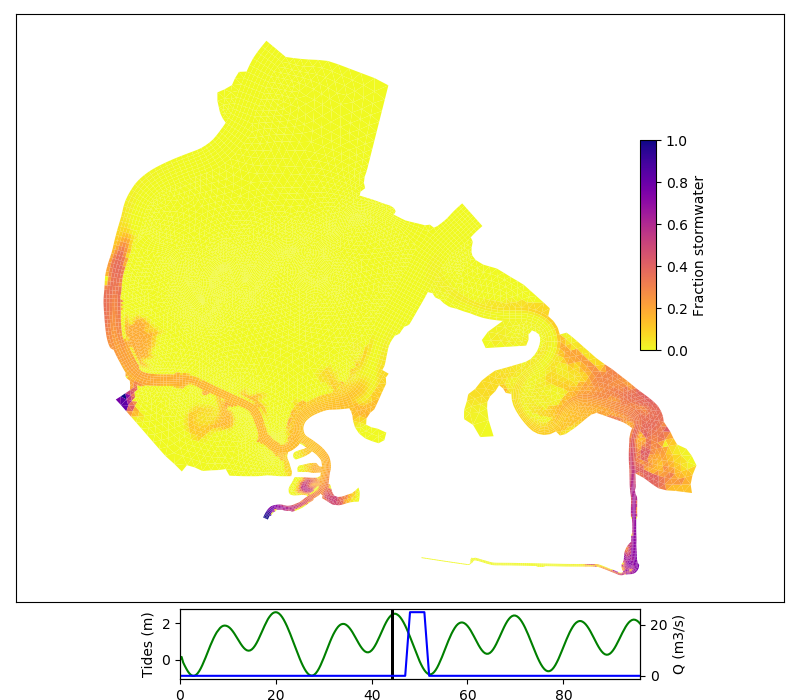

figs-20180609/S48.0_D3.0_Q25.0/frame0000.png
figs-20180609/S48.0_D3.0_Q25.0/frame0001.png
figs-20180609/S48.0_D3.0_Q25.0/frame0002.png
figs-20180609/S48.0_D3.0_Q25.0/frame0003.png
figs-20180609/S48.0_D3.0_Q25.0/frame0004.png
figs-20180609/S48.0_D3.0_Q25.0/frame0005.png
figs-20180609/S48.0_D3.0_Q25.0/frame0006.png
figs-20180609/S48.0_D3.0_Q25.0/frame0007.png
figs-20180609/S48.0_D3.0_Q25.0/frame0008.png
figs-20180609/S48.0_D3.0_Q25.0/frame0009.png
figs-20180609/S48.0_D3.0_Q25.0/frame0010.png
figs-20180609/S48.0_D3.0_Q25.0/frame0011.png
figs-20180609/S48.0_D3.0_Q25.0/frame0012.png
figs-20180609/S48.0_D3.0_Q25.0/frame0013.png
figs-20180609/S48.0_D3.0_Q25.0/frame0014.png
figs-20180609/S48.0_D3.0_Q25.0/frame0015.png
figs-20180609/S48.0_D3.0_Q25.0/frame0016.png
figs-20180609/S48.0_D3.0_Q25.0/frame0017.png
figs-20180609/S48.0_D3.0_Q25.0/frame0018.png
figs-20180609/S48.0_D3.0_Q25.0/frame0019.png
figs-20180609/S48.0_D3.0_Q25.0/frame0020.png
figs-20180609/S48.0_D3.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


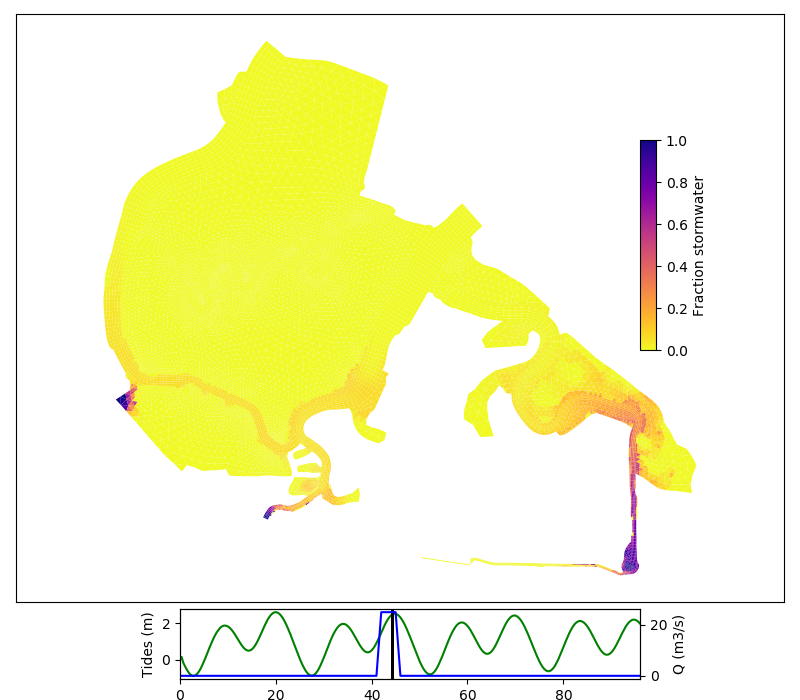

figs-20180609/S42.0_D3.0_Q10.0/frame0000.png
figs-20180609/S42.0_D3.0_Q10.0/frame0001.png
figs-20180609/S42.0_D3.0_Q10.0/frame0002.png
figs-20180609/S42.0_D3.0_Q10.0/frame0003.png
figs-20180609/S42.0_D3.0_Q10.0/frame0004.png
figs-20180609/S42.0_D3.0_Q10.0/frame0005.png
figs-20180609/S42.0_D3.0_Q10.0/frame0006.png
figs-20180609/S42.0_D3.0_Q10.0/frame0007.png
figs-20180609/S42.0_D3.0_Q10.0/frame0008.png
figs-20180609/S42.0_D3.0_Q10.0/frame0009.png
figs-20180609/S42.0_D3.0_Q10.0/frame0010.png
figs-20180609/S42.0_D3.0_Q10.0/frame0011.png
figs-20180609/S42.0_D3.0_Q10.0/frame0012.png
figs-20180609/S42.0_D3.0_Q10.0/frame0013.png
figs-20180609/S42.0_D3.0_Q10.0/frame0014.png
figs-20180609/S42.0_D3.0_Q10.0/frame0015.png
figs-20180609/S42.0_D3.0_Q10.0/frame0016.png
figs-20180609/S42.0_D3.0_Q10.0/frame0017.png
figs-20180609/S42.0_D3.0_Q10.0/frame0018.png
figs-20180609/S42.0_D3.0_Q10.0/frame0019.png
figs-20180609/S42.0_D3.0_Q10.0/frame0020.png
figs-20180609/S42.0_D3.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


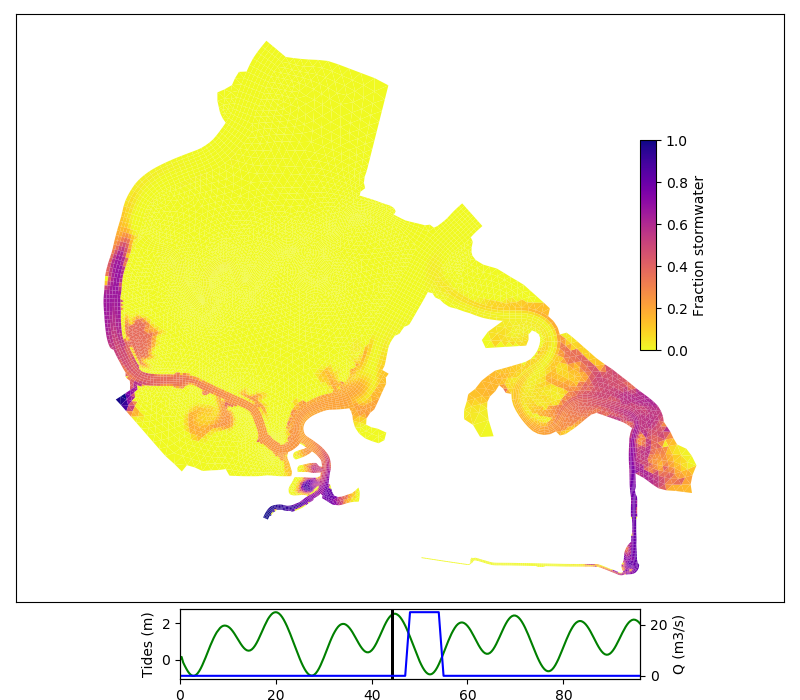

figs-20180609/S48.0_D6.0_Q25.0/frame0000.png
figs-20180609/S48.0_D6.0_Q25.0/frame0001.png
figs-20180609/S48.0_D6.0_Q25.0/frame0002.png
figs-20180609/S48.0_D6.0_Q25.0/frame0003.png
figs-20180609/S48.0_D6.0_Q25.0/frame0004.png
figs-20180609/S48.0_D6.0_Q25.0/frame0005.png
figs-20180609/S48.0_D6.0_Q25.0/frame0006.png
figs-20180609/S48.0_D6.0_Q25.0/frame0007.png
figs-20180609/S48.0_D6.0_Q25.0/frame0008.png
figs-20180609/S48.0_D6.0_Q25.0/frame0009.png
figs-20180609/S48.0_D6.0_Q25.0/frame0010.png
figs-20180609/S48.0_D6.0_Q25.0/frame0011.png
figs-20180609/S48.0_D6.0_Q25.0/frame0012.png
figs-20180609/S48.0_D6.0_Q25.0/frame0013.png
figs-20180609/S48.0_D6.0_Q25.0/frame0014.png
figs-20180609/S48.0_D6.0_Q25.0/frame0015.png
figs-20180609/S48.0_D6.0_Q25.0/frame0016.png
figs-20180609/S48.0_D6.0_Q25.0/frame0017.png
figs-20180609/S48.0_D6.0_Q25.0/frame0018.png
figs-20180609/S48.0_D6.0_Q25.0/frame0019.png
figs-20180609/S48.0_D6.0_Q25.0/frame0020.png
figs-20180609/S48.0_D6.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


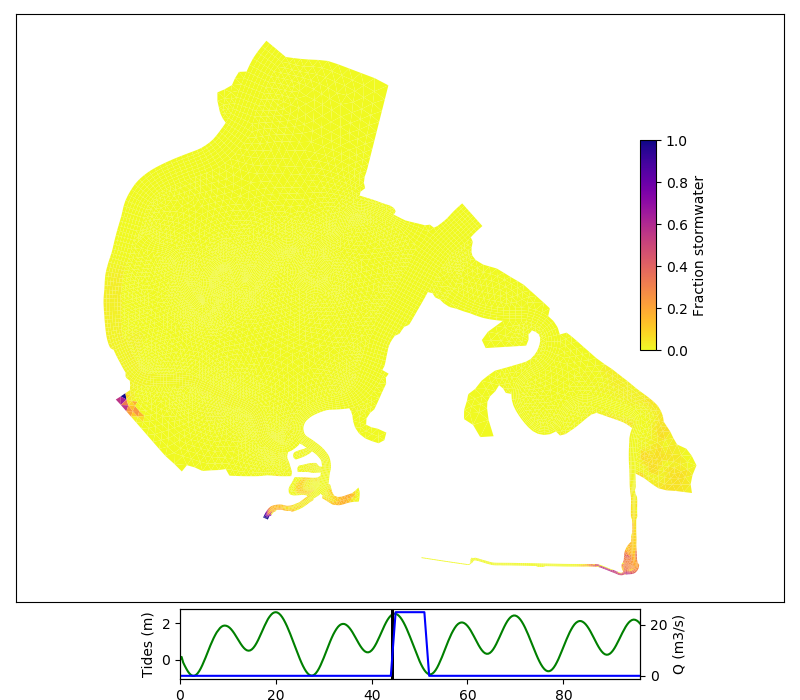

figs-20180609/S45.0_D6.0_Q02.0/frame0000.png
figs-20180609/S45.0_D6.0_Q02.0/frame0001.png
figs-20180609/S45.0_D6.0_Q02.0/frame0002.png
figs-20180609/S45.0_D6.0_Q02.0/frame0003.png
figs-20180609/S45.0_D6.0_Q02.0/frame0004.png
figs-20180609/S45.0_D6.0_Q02.0/frame0005.png
figs-20180609/S45.0_D6.0_Q02.0/frame0006.png
figs-20180609/S45.0_D6.0_Q02.0/frame0007.png
figs-20180609/S45.0_D6.0_Q02.0/frame0008.png
figs-20180609/S45.0_D6.0_Q02.0/frame0009.png
figs-20180609/S45.0_D6.0_Q02.0/frame0010.png
figs-20180609/S45.0_D6.0_Q02.0/frame0011.png
figs-20180609/S45.0_D6.0_Q02.0/frame0012.png
figs-20180609/S45.0_D6.0_Q02.0/frame0013.png
figs-20180609/S45.0_D6.0_Q02.0/frame0014.png
figs-20180609/S45.0_D6.0_Q02.0/frame0015.png
figs-20180609/S45.0_D6.0_Q02.0/frame0016.png
figs-20180609/S45.0_D6.0_Q02.0/frame0017.png
figs-20180609/S45.0_D6.0_Q02.0/frame0018.png
figs-20180609/S45.0_D6.0_Q02.0/frame0019.png
figs-20180609/S45.0_D6.0_Q02.0/frame0020.png
figs-20180609/S45.0_D6.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


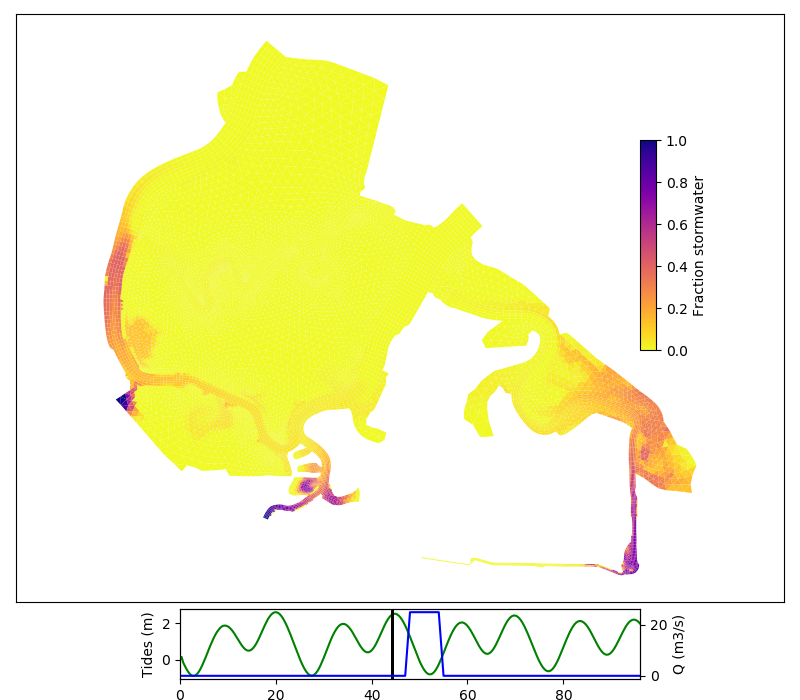

figs-20180609/S48.0_D6.0_Q10.0/frame0000.png
figs-20180609/S48.0_D6.0_Q10.0/frame0001.png
figs-20180609/S48.0_D6.0_Q10.0/frame0002.png
figs-20180609/S48.0_D6.0_Q10.0/frame0003.png
figs-20180609/S48.0_D6.0_Q10.0/frame0004.png
figs-20180609/S48.0_D6.0_Q10.0/frame0005.png
figs-20180609/S48.0_D6.0_Q10.0/frame0006.png
figs-20180609/S48.0_D6.0_Q10.0/frame0007.png
figs-20180609/S48.0_D6.0_Q10.0/frame0008.png
figs-20180609/S48.0_D6.0_Q10.0/frame0009.png
figs-20180609/S48.0_D6.0_Q10.0/frame0010.png
figs-20180609/S48.0_D6.0_Q10.0/frame0011.png
figs-20180609/S48.0_D6.0_Q10.0/frame0012.png
figs-20180609/S48.0_D6.0_Q10.0/frame0013.png
figs-20180609/S48.0_D6.0_Q10.0/frame0014.png
figs-20180609/S48.0_D6.0_Q10.0/frame0015.png
figs-20180609/S48.0_D6.0_Q10.0/frame0016.png
figs-20180609/S48.0_D6.0_Q10.0/frame0017.png
figs-20180609/S48.0_D6.0_Q10.0/frame0018.png
figs-20180609/S48.0_D6.0_Q10.0/frame0019.png
figs-20180609/S48.0_D6.0_Q10.0/frame0020.png
figs-20180609/S48.0_D6.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


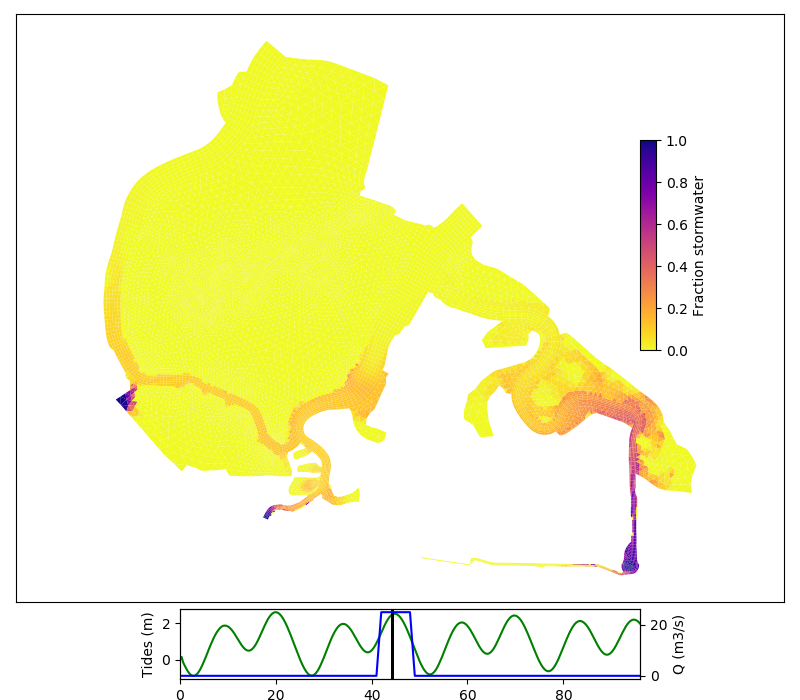

figs-20180609/S42.0_D6.0_Q10.0/frame0000.png
figs-20180609/S42.0_D6.0_Q10.0/frame0001.png
figs-20180609/S42.0_D6.0_Q10.0/frame0002.png
figs-20180609/S42.0_D6.0_Q10.0/frame0003.png
figs-20180609/S42.0_D6.0_Q10.0/frame0004.png
figs-20180609/S42.0_D6.0_Q10.0/frame0005.png
figs-20180609/S42.0_D6.0_Q10.0/frame0006.png
figs-20180609/S42.0_D6.0_Q10.0/frame0007.png
figs-20180609/S42.0_D6.0_Q10.0/frame0008.png
figs-20180609/S42.0_D6.0_Q10.0/frame0009.png
figs-20180609/S42.0_D6.0_Q10.0/frame0010.png
figs-20180609/S42.0_D6.0_Q10.0/frame0011.png
figs-20180609/S42.0_D6.0_Q10.0/frame0012.png
figs-20180609/S42.0_D6.0_Q10.0/frame0013.png
figs-20180609/S42.0_D6.0_Q10.0/frame0014.png
figs-20180609/S42.0_D6.0_Q10.0/frame0015.png
figs-20180609/S42.0_D6.0_Q10.0/frame0016.png
figs-20180609/S42.0_D6.0_Q10.0/frame0017.png
figs-20180609/S42.0_D6.0_Q10.0/frame0018.png
figs-20180609/S42.0_D6.0_Q10.0/frame0019.png
figs-20180609/S42.0_D6.0_Q10.0/frame0020.png
figs-20180609/S42.0_D6.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


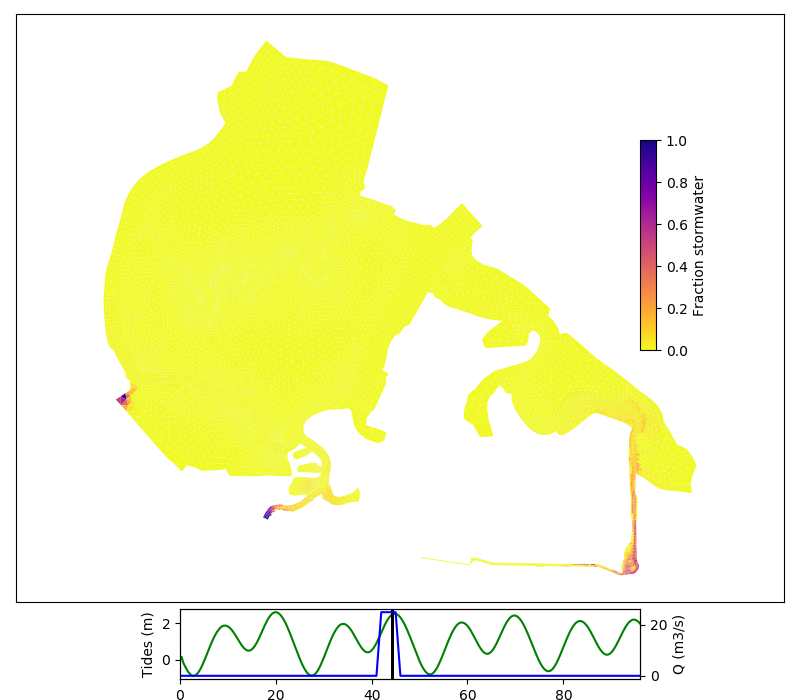

figs-20180609/S42.0_D3.0_Q02.0/frame0000.png
figs-20180609/S42.0_D3.0_Q02.0/frame0001.png
figs-20180609/S42.0_D3.0_Q02.0/frame0002.png
figs-20180609/S42.0_D3.0_Q02.0/frame0003.png
figs-20180609/S42.0_D3.0_Q02.0/frame0004.png
figs-20180609/S42.0_D3.0_Q02.0/frame0005.png
figs-20180609/S42.0_D3.0_Q02.0/frame0006.png
figs-20180609/S42.0_D3.0_Q02.0/frame0007.png
figs-20180609/S42.0_D3.0_Q02.0/frame0008.png
figs-20180609/S42.0_D3.0_Q02.0/frame0009.png
figs-20180609/S42.0_D3.0_Q02.0/frame0010.png
figs-20180609/S42.0_D3.0_Q02.0/frame0011.png
figs-20180609/S42.0_D3.0_Q02.0/frame0012.png
figs-20180609/S42.0_D3.0_Q02.0/frame0013.png
figs-20180609/S42.0_D3.0_Q02.0/frame0014.png
figs-20180609/S42.0_D3.0_Q02.0/frame0015.png
figs-20180609/S42.0_D3.0_Q02.0/frame0016.png
figs-20180609/S42.0_D3.0_Q02.0/frame0017.png
figs-20180609/S42.0_D3.0_Q02.0/frame0018.png
figs-20180609/S42.0_D3.0_Q02.0/frame0019.png
figs-20180609/S42.0_D3.0_Q02.0/frame0020.png
figs-20180609/S42.0_D3.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


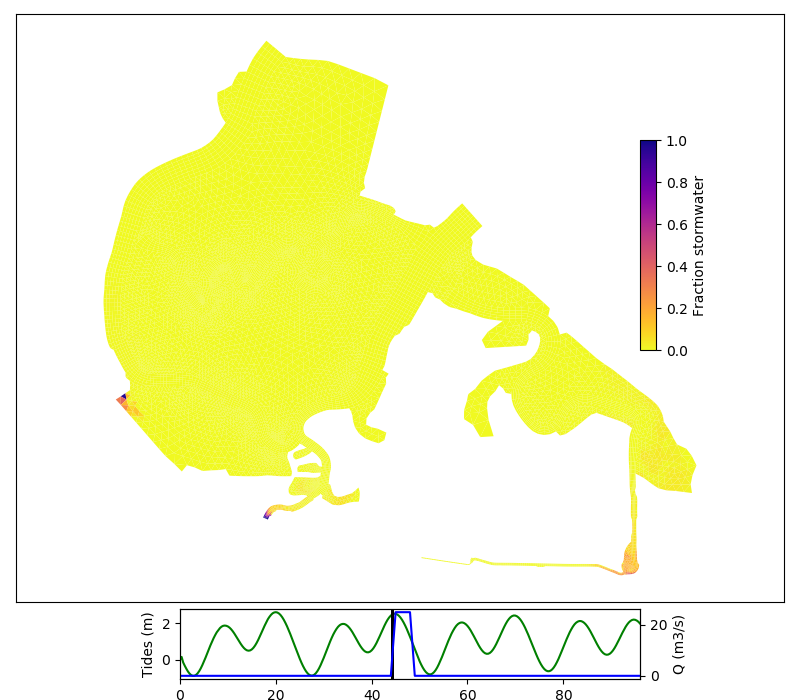

figs-20180609/S45.0_D3.0_Q02.0/frame0000.png
figs-20180609/S45.0_D3.0_Q02.0/frame0001.png
figs-20180609/S45.0_D3.0_Q02.0/frame0002.png
figs-20180609/S45.0_D3.0_Q02.0/frame0003.png
figs-20180609/S45.0_D3.0_Q02.0/frame0004.png
figs-20180609/S45.0_D3.0_Q02.0/frame0005.png
figs-20180609/S45.0_D3.0_Q02.0/frame0006.png
figs-20180609/S45.0_D3.0_Q02.0/frame0007.png
figs-20180609/S45.0_D3.0_Q02.0/frame0008.png
figs-20180609/S45.0_D3.0_Q02.0/frame0009.png
figs-20180609/S45.0_D3.0_Q02.0/frame0010.png
figs-20180609/S45.0_D3.0_Q02.0/frame0011.png
figs-20180609/S45.0_D3.0_Q02.0/frame0012.png
figs-20180609/S45.0_D3.0_Q02.0/frame0013.png
figs-20180609/S45.0_D3.0_Q02.0/frame0014.png
figs-20180609/S45.0_D3.0_Q02.0/frame0015.png
figs-20180609/S45.0_D3.0_Q02.0/frame0016.png
figs-20180609/S45.0_D3.0_Q02.0/frame0017.png
figs-20180609/S45.0_D3.0_Q02.0/frame0018.png
figs-20180609/S45.0_D3.0_Q02.0/frame0019.png
figs-20180609/S45.0_D3.0_Q02.0/frame0020.png
figs-20180609/S45.0_D3.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


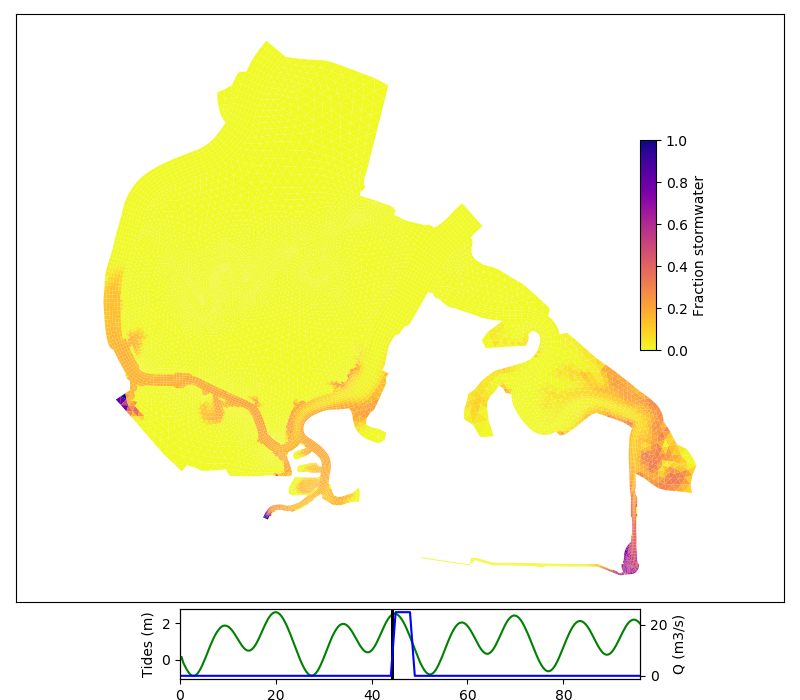

figs-20180609/S45.0_D3.0_Q25.0/frame0000.png
figs-20180609/S45.0_D3.0_Q25.0/frame0001.png
figs-20180609/S45.0_D3.0_Q25.0/frame0002.png
figs-20180609/S45.0_D3.0_Q25.0/frame0003.png
figs-20180609/S45.0_D3.0_Q25.0/frame0004.png
figs-20180609/S45.0_D3.0_Q25.0/frame0005.png
figs-20180609/S45.0_D3.0_Q25.0/frame0006.png
figs-20180609/S45.0_D3.0_Q25.0/frame0007.png
figs-20180609/S45.0_D3.0_Q25.0/frame0008.png
figs-20180609/S45.0_D3.0_Q25.0/frame0009.png
figs-20180609/S45.0_D3.0_Q25.0/frame0010.png
figs-20180609/S45.0_D3.0_Q25.0/frame0011.png
figs-20180609/S45.0_D3.0_Q25.0/frame0012.png
figs-20180609/S45.0_D3.0_Q25.0/frame0013.png
figs-20180609/S45.0_D3.0_Q25.0/frame0014.png
figs-20180609/S45.0_D3.0_Q25.0/frame0015.png
figs-20180609/S45.0_D3.0_Q25.0/frame0016.png
figs-20180609/S45.0_D3.0_Q25.0/frame0017.png
figs-20180609/S45.0_D3.0_Q25.0/frame0018.png
figs-20180609/S45.0_D3.0_Q25.0/frame0019.png
figs-20180609/S45.0_D3.0_Q25.0/frame0020.png
figs-20180609/S45.0_D3.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


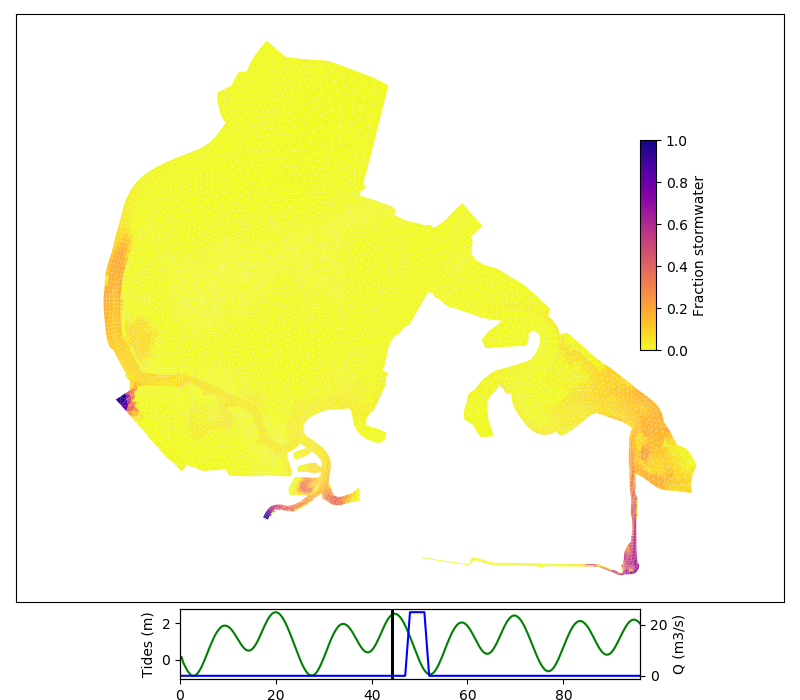

figs-20180609/S48.0_D3.0_Q10.0/frame0000.png
figs-20180609/S48.0_D3.0_Q10.0/frame0001.png
figs-20180609/S48.0_D3.0_Q10.0/frame0002.png
figs-20180609/S48.0_D3.0_Q10.0/frame0003.png
figs-20180609/S48.0_D3.0_Q10.0/frame0004.png
figs-20180609/S48.0_D3.0_Q10.0/frame0005.png
figs-20180609/S48.0_D3.0_Q10.0/frame0006.png
figs-20180609/S48.0_D3.0_Q10.0/frame0007.png
figs-20180609/S48.0_D3.0_Q10.0/frame0008.png
figs-20180609/S48.0_D3.0_Q10.0/frame0009.png
figs-20180609/S48.0_D3.0_Q10.0/frame0010.png
figs-20180609/S48.0_D3.0_Q10.0/frame0011.png
figs-20180609/S48.0_D3.0_Q10.0/frame0012.png
figs-20180609/S48.0_D3.0_Q10.0/frame0013.png
figs-20180609/S48.0_D3.0_Q10.0/frame0014.png
figs-20180609/S48.0_D3.0_Q10.0/frame0015.png
figs-20180609/S48.0_D3.0_Q10.0/frame0016.png
figs-20180609/S48.0_D3.0_Q10.0/frame0017.png
figs-20180609/S48.0_D3.0_Q10.0/frame0018.png
figs-20180609/S48.0_D3.0_Q10.0/frame0019.png
figs-20180609/S48.0_D3.0_Q10.0/frame0020.png
figs-20180609/S48.0_D3.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


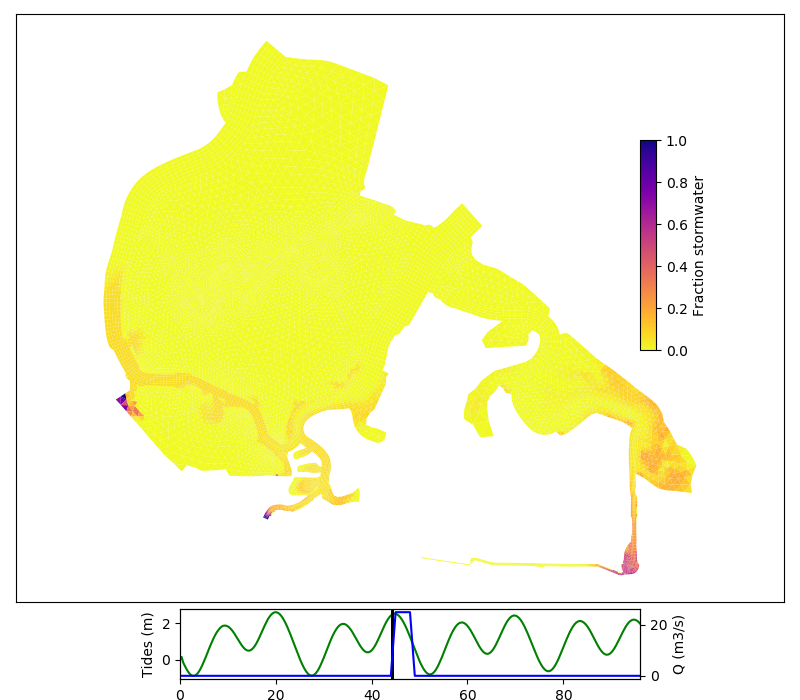

figs-20180609/S45.0_D3.0_Q10.0/frame0000.png
figs-20180609/S45.0_D3.0_Q10.0/frame0001.png
figs-20180609/S45.0_D3.0_Q10.0/frame0002.png
figs-20180609/S45.0_D3.0_Q10.0/frame0003.png
figs-20180609/S45.0_D3.0_Q10.0/frame0004.png
figs-20180609/S45.0_D3.0_Q10.0/frame0005.png
figs-20180609/S45.0_D3.0_Q10.0/frame0006.png
figs-20180609/S45.0_D3.0_Q10.0/frame0007.png
figs-20180609/S45.0_D3.0_Q10.0/frame0008.png
figs-20180609/S45.0_D3.0_Q10.0/frame0009.png
figs-20180609/S45.0_D3.0_Q10.0/frame0010.png
figs-20180609/S45.0_D3.0_Q10.0/frame0011.png
figs-20180609/S45.0_D3.0_Q10.0/frame0012.png
figs-20180609/S45.0_D3.0_Q10.0/frame0013.png
figs-20180609/S45.0_D3.0_Q10.0/frame0014.png
figs-20180609/S45.0_D3.0_Q10.0/frame0015.png
figs-20180609/S45.0_D3.0_Q10.0/frame0016.png
figs-20180609/S45.0_D3.0_Q10.0/frame0017.png
figs-20180609/S45.0_D3.0_Q10.0/frame0018.png
figs-20180609/S45.0_D3.0_Q10.0/frame0019.png
figs-20180609/S45.0_D3.0_Q10.0/frame0020.png
figs-20180609/S45.0_D3.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


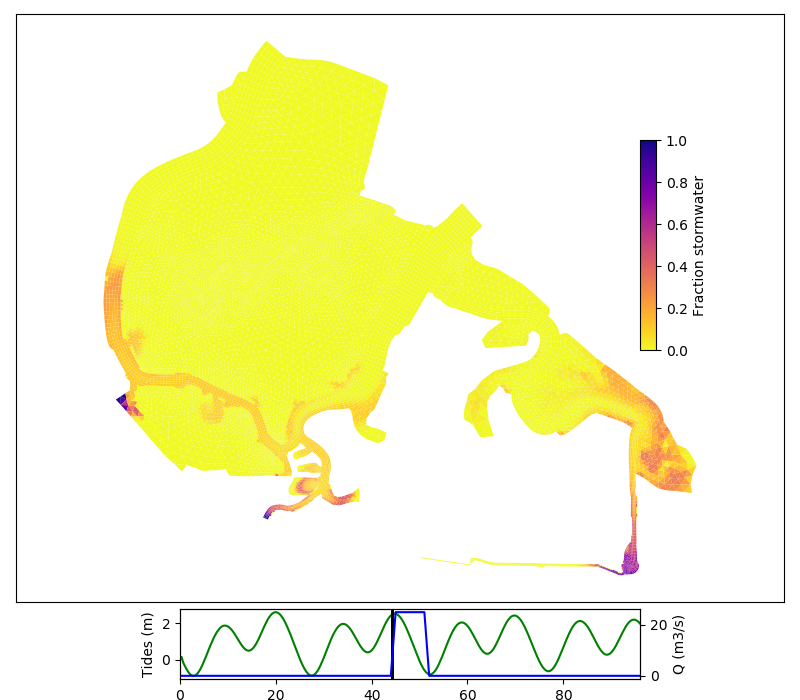

figs-20180609/S45.0_D6.0_Q10.0/frame0000.png
figs-20180609/S45.0_D6.0_Q10.0/frame0001.png
figs-20180609/S45.0_D6.0_Q10.0/frame0002.png
figs-20180609/S45.0_D6.0_Q10.0/frame0003.png
figs-20180609/S45.0_D6.0_Q10.0/frame0004.png
figs-20180609/S45.0_D6.0_Q10.0/frame0005.png
figs-20180609/S45.0_D6.0_Q10.0/frame0006.png
figs-20180609/S45.0_D6.0_Q10.0/frame0007.png
figs-20180609/S45.0_D6.0_Q10.0/frame0008.png
figs-20180609/S45.0_D6.0_Q10.0/frame0009.png
figs-20180609/S45.0_D6.0_Q10.0/frame0010.png
figs-20180609/S45.0_D6.0_Q10.0/frame0011.png
figs-20180609/S45.0_D6.0_Q10.0/frame0012.png
figs-20180609/S45.0_D6.0_Q10.0/frame0013.png
figs-20180609/S45.0_D6.0_Q10.0/frame0014.png
figs-20180609/S45.0_D6.0_Q10.0/frame0015.png
figs-20180609/S45.0_D6.0_Q10.0/frame0016.png
figs-20180609/S45.0_D6.0_Q10.0/frame0017.png
figs-20180609/S45.0_D6.0_Q10.0/frame0018.png
figs-20180609/S45.0_D6.0_Q10.0/frame0019.png
figs-20180609/S45.0_D6.0_Q10.0/frame0020.png
figs-20180609/S45.0_D6.0_Q10.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


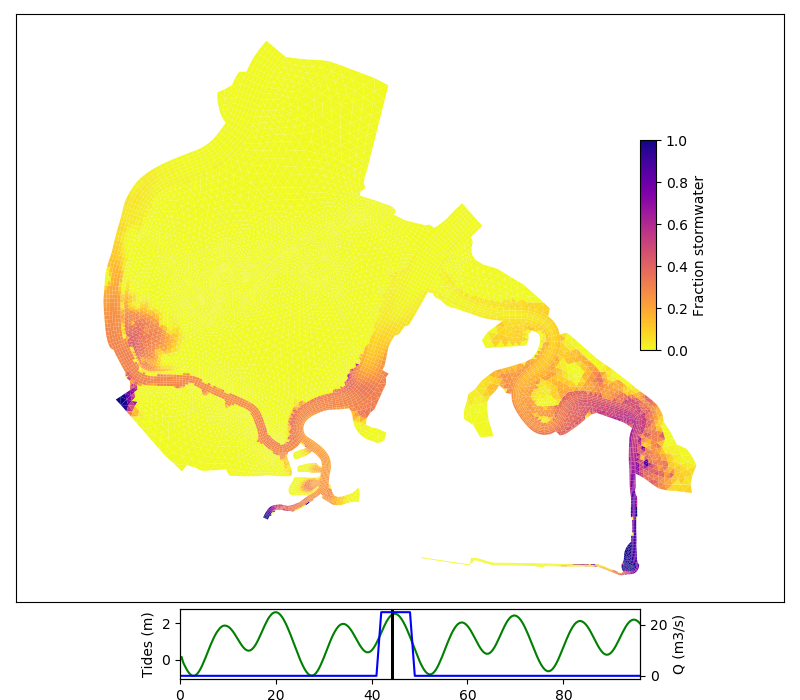

figs-20180609/S42.0_D6.0_Q25.0/frame0000.png
figs-20180609/S42.0_D6.0_Q25.0/frame0001.png
figs-20180609/S42.0_D6.0_Q25.0/frame0002.png
figs-20180609/S42.0_D6.0_Q25.0/frame0003.png
figs-20180609/S42.0_D6.0_Q25.0/frame0004.png
figs-20180609/S42.0_D6.0_Q25.0/frame0005.png
figs-20180609/S42.0_D6.0_Q25.0/frame0006.png
figs-20180609/S42.0_D6.0_Q25.0/frame0007.png
figs-20180609/S42.0_D6.0_Q25.0/frame0008.png
figs-20180609/S42.0_D6.0_Q25.0/frame0009.png
figs-20180609/S42.0_D6.0_Q25.0/frame0010.png
figs-20180609/S42.0_D6.0_Q25.0/frame0011.png
figs-20180609/S42.0_D6.0_Q25.0/frame0012.png
figs-20180609/S42.0_D6.0_Q25.0/frame0013.png
figs-20180609/S42.0_D6.0_Q25.0/frame0014.png
figs-20180609/S42.0_D6.0_Q25.0/frame0015.png
figs-20180609/S42.0_D6.0_Q25.0/frame0016.png
figs-20180609/S42.0_D6.0_Q25.0/frame0017.png
figs-20180609/S42.0_D6.0_Q25.0/frame0018.png
figs-20180609/S42.0_D6.0_Q25.0/frame0019.png
figs-20180609/S42.0_D6.0_Q25.0/frame0020.png
figs-20180609/S42.0_D6.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


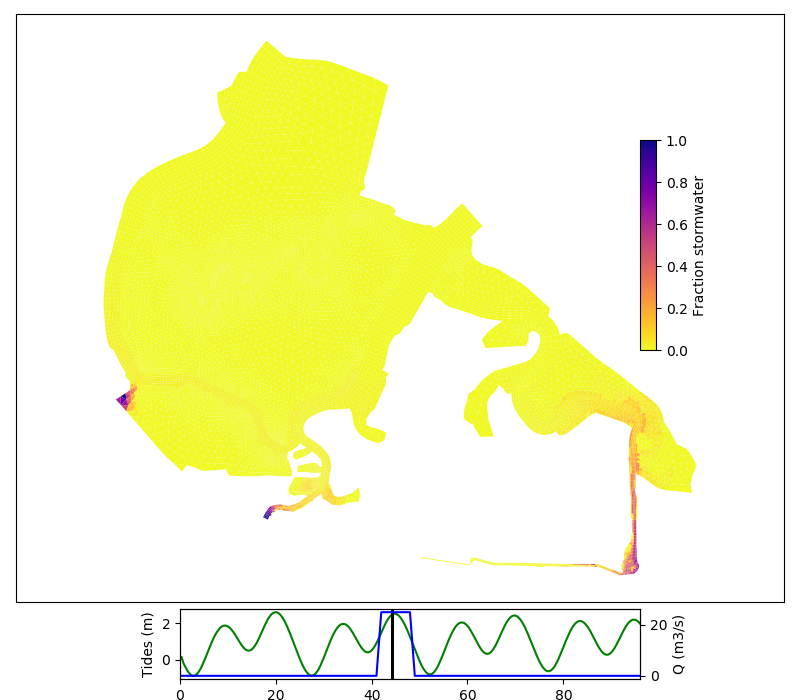

figs-20180609/S42.0_D6.0_Q02.0/frame0000.png
figs-20180609/S42.0_D6.0_Q02.0/frame0001.png
figs-20180609/S42.0_D6.0_Q02.0/frame0002.png
figs-20180609/S42.0_D6.0_Q02.0/frame0003.png
figs-20180609/S42.0_D6.0_Q02.0/frame0004.png
figs-20180609/S42.0_D6.0_Q02.0/frame0005.png
figs-20180609/S42.0_D6.0_Q02.0/frame0006.png
figs-20180609/S42.0_D6.0_Q02.0/frame0007.png
figs-20180609/S42.0_D6.0_Q02.0/frame0008.png
figs-20180609/S42.0_D6.0_Q02.0/frame0009.png
figs-20180609/S42.0_D6.0_Q02.0/frame0010.png
figs-20180609/S42.0_D6.0_Q02.0/frame0011.png
figs-20180609/S42.0_D6.0_Q02.0/frame0012.png
figs-20180609/S42.0_D6.0_Q02.0/frame0013.png
figs-20180609/S42.0_D6.0_Q02.0/frame0014.png
figs-20180609/S42.0_D6.0_Q02.0/frame0015.png
figs-20180609/S42.0_D6.0_Q02.0/frame0016.png
figs-20180609/S42.0_D6.0_Q02.0/frame0017.png
figs-20180609/S42.0_D6.0_Q02.0/frame0018.png
figs-20180609/S42.0_D6.0_Q02.0/frame0019.png
figs-20180609/S42.0_D6.0_Q02.0/frame0020.png
figs-20180609/S42.0_D6.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


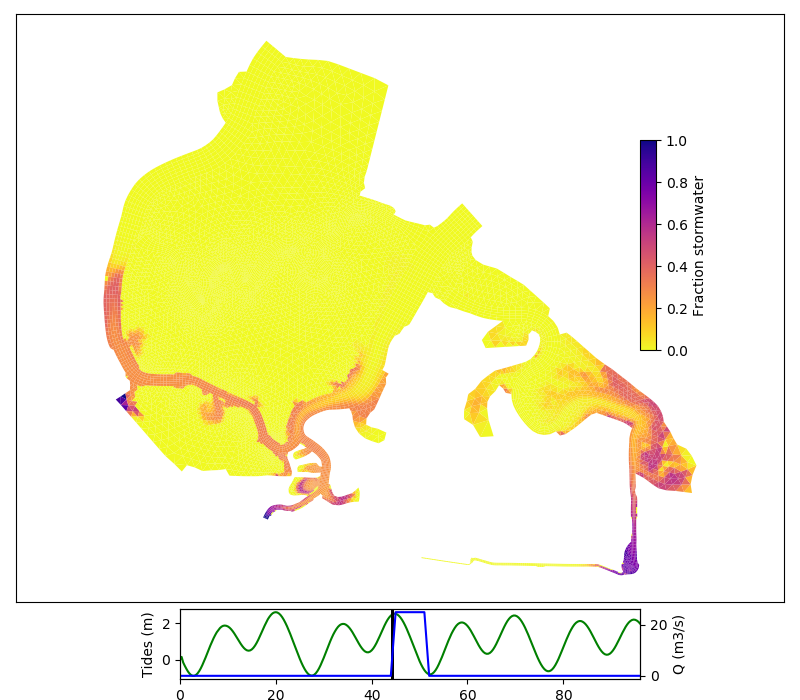

figs-20180609/S45.0_D6.0_Q25.0/frame0000.png
figs-20180609/S45.0_D6.0_Q25.0/frame0001.png
figs-20180609/S45.0_D6.0_Q25.0/frame0002.png
figs-20180609/S45.0_D6.0_Q25.0/frame0003.png
figs-20180609/S45.0_D6.0_Q25.0/frame0004.png
figs-20180609/S45.0_D6.0_Q25.0/frame0005.png
figs-20180609/S45.0_D6.0_Q25.0/frame0006.png
figs-20180609/S45.0_D6.0_Q25.0/frame0007.png
figs-20180609/S45.0_D6.0_Q25.0/frame0008.png
figs-20180609/S45.0_D6.0_Q25.0/frame0009.png
figs-20180609/S45.0_D6.0_Q25.0/frame0010.png
figs-20180609/S45.0_D6.0_Q25.0/frame0011.png
figs-20180609/S45.0_D6.0_Q25.0/frame0012.png
figs-20180609/S45.0_D6.0_Q25.0/frame0013.png
figs-20180609/S45.0_D6.0_Q25.0/frame0014.png
figs-20180609/S45.0_D6.0_Q25.0/frame0015.png
figs-20180609/S45.0_D6.0_Q25.0/frame0016.png
figs-20180609/S45.0_D6.0_Q25.0/frame0017.png
figs-20180609/S45.0_D6.0_Q25.0/frame0018.png
figs-20180609/S45.0_D6.0_Q25.0/frame0019.png
figs-20180609/S45.0_D6.0_Q25.0/frame0020.png
figs-20180609/S45.0_D6.0_Q25.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


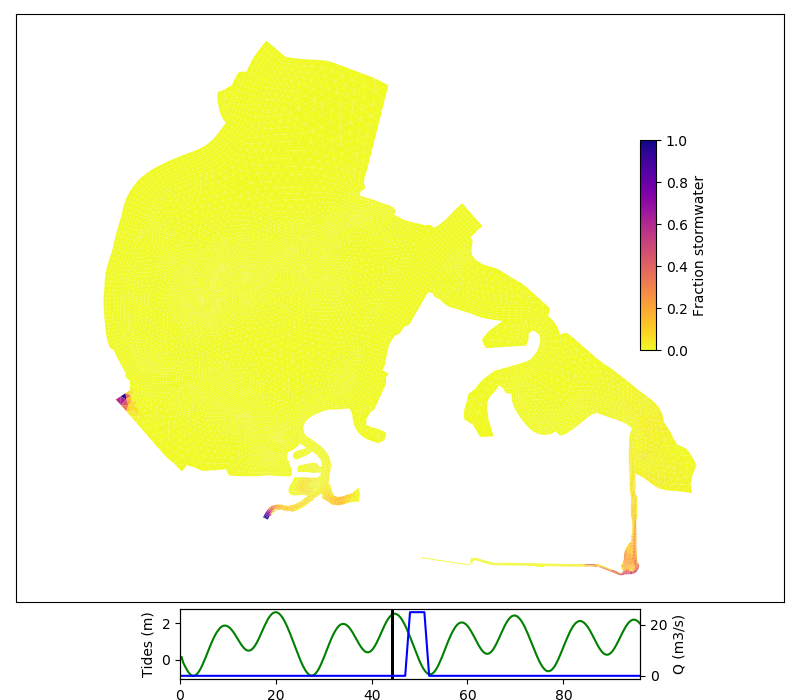

figs-20180609/S48.0_D3.0_Q02.0/frame0000.png
figs-20180609/S48.0_D3.0_Q02.0/frame0001.png
figs-20180609/S48.0_D3.0_Q02.0/frame0002.png
figs-20180609/S48.0_D3.0_Q02.0/frame0003.png
figs-20180609/S48.0_D3.0_Q02.0/frame0004.png
figs-20180609/S48.0_D3.0_Q02.0/frame0005.png
figs-20180609/S48.0_D3.0_Q02.0/frame0006.png
figs-20180609/S48.0_D3.0_Q02.0/frame0007.png
figs-20180609/S48.0_D3.0_Q02.0/frame0008.png
figs-20180609/S48.0_D3.0_Q02.0/frame0009.png
figs-20180609/S48.0_D3.0_Q02.0/frame0010.png
figs-20180609/S48.0_D3.0_Q02.0/frame0011.png
figs-20180609/S48.0_D3.0_Q02.0/frame0012.png
figs-20180609/S48.0_D3.0_Q02.0/frame0013.png
figs-20180609/S48.0_D3.0_Q02.0/frame0014.png
figs-20180609/S48.0_D3.0_Q02.0/frame0015.png
figs-20180609/S48.0_D3.0_Q02.0/frame0016.png
figs-20180609/S48.0_D3.0_Q02.0/frame0017.png
figs-20180609/S48.0_D3.0_Q02.0/frame0018.png
figs-20180609/S48.0_D3.0_Q02.0/frame0019.png
figs-20180609/S48.0_D3.0_Q02.0/frame0020.png
figs-20180609/S48.0_D3.0_Q02.0/frame0021.png
figs-20180

<IPython.core.display.Javascript object>


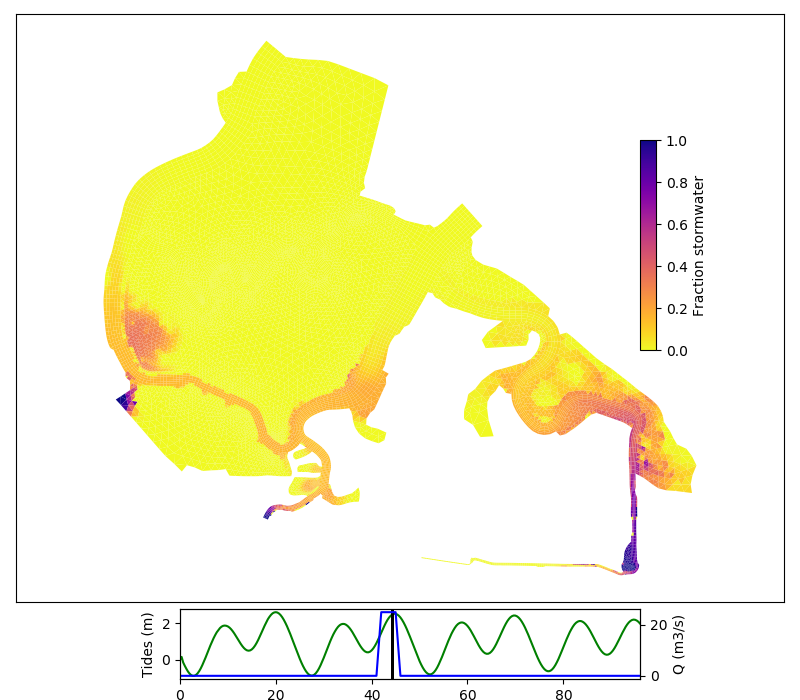

figs-20180609/S42.0_D3.0_Q25.0/frame0000.png
figs-20180609/S42.0_D3.0_Q25.0/frame0001.png
figs-20180609/S42.0_D3.0_Q25.0/frame0002.png
figs-20180609/S42.0_D3.0_Q25.0/frame0003.png
figs-20180609/S42.0_D3.0_Q25.0/frame0004.png
figs-20180609/S42.0_D3.0_Q25.0/frame0005.png
figs-20180609/S42.0_D3.0_Q25.0/frame0006.png
figs-20180609/S42.0_D3.0_Q25.0/frame0007.png
figs-20180609/S42.0_D3.0_Q25.0/frame0008.png
figs-20180609/S42.0_D3.0_Q25.0/frame0009.png
figs-20180609/S42.0_D3.0_Q25.0/frame0010.png
figs-20180609/S42.0_D3.0_Q25.0/frame0011.png
figs-20180609/S42.0_D3.0_Q25.0/frame0012.png
figs-20180609/S42.0_D3.0_Q25.0/frame0013.png
figs-20180609/S42.0_D3.0_Q25.0/frame0014.png
figs-20180609/S42.0_D3.0_Q25.0/frame0015.png
figs-20180609/S42.0_D3.0_Q25.0/frame0016.png
figs-20180609/S42.0_D3.0_Q25.0/frame0017.png
figs-20180609/S42.0_D3.0_Q25.0/frame0018.png
figs-20180609/S42.0_D3.0_Q25.0/frame0019.png
figs-20180609/S42.0_D3.0_Q25.0/frame0020.png
figs-20180609/S42.0_D3.0_Q25.0/frame0021.png
figs-20180

In [101]:
import glob
map_nc_fns=glob.glob("runs/S*_D*_Q*/DFM_OUTPUT_flowfm/flowfm_map.nc")
map_nc_fns

for map_nc_fn in map_nc_fns:
    A=Anim(map_nc_fn)
    A.anim_setup()
    A.save_frames()